In [6]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from importlib.machinery import SourceFileLoader
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error
from math import sqrt

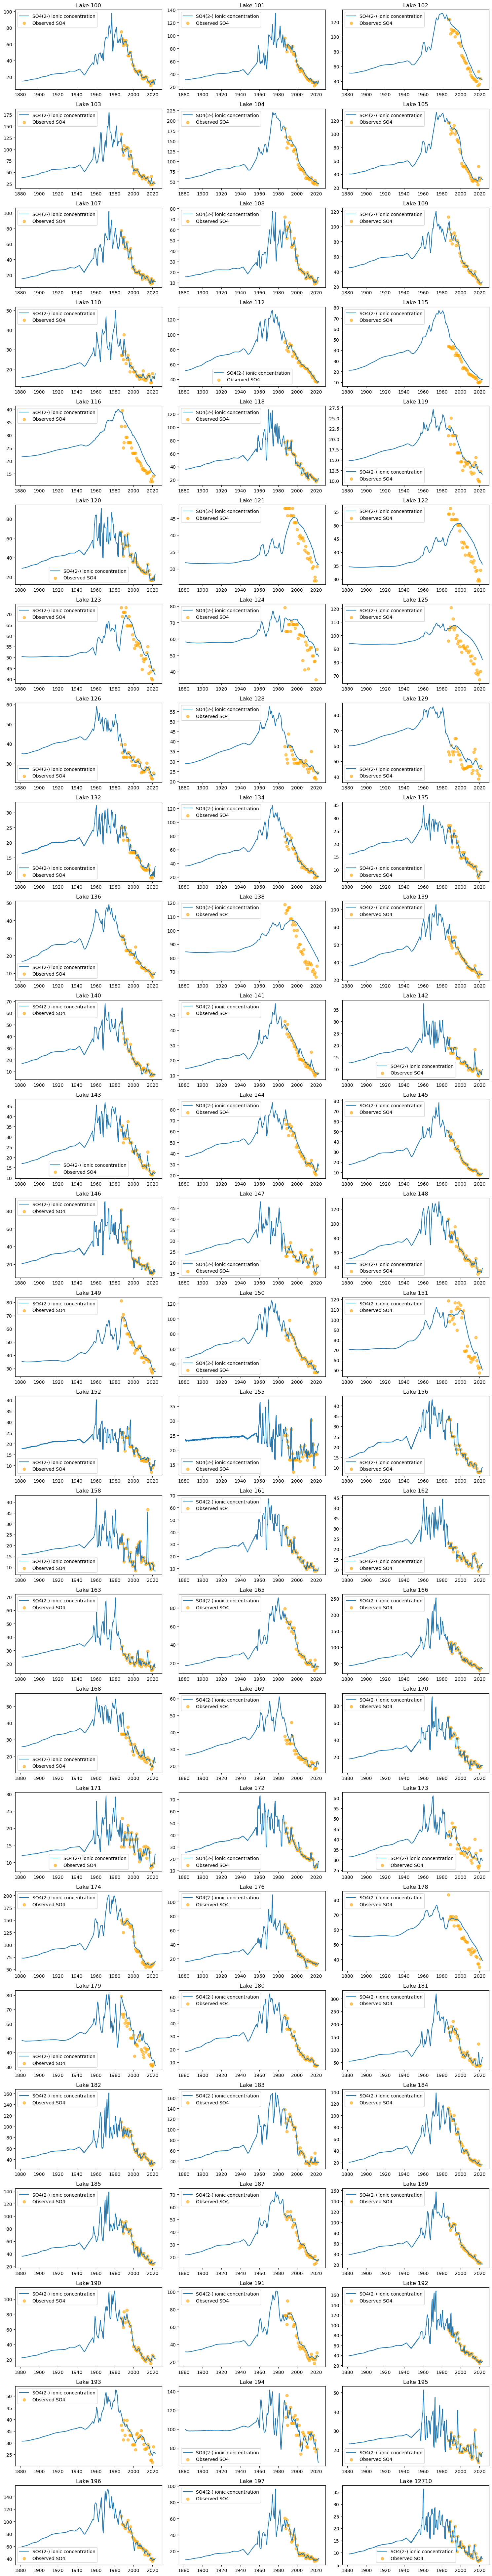

In [7]:
wr = SourceFileLoader("mobius", r"../../mobius.py").load_module()
cu = SourceFileLoader("mobius_calib_uncert_lmfit", r"../../mobius_calib_uncert_lmfit.py").load_module()

multi = SourceFileLoader("multiloop", r"../multiloop.py").load_module()
magicopt = SourceFileLoader("magicopt",  r"../magicopt.py").load_module()

wr.initialize('../../../Applications/MAGIC/magic_forest.so')

long_term_parameters_df = pd.read_csv('raw_data/water_soil_chem_hydro_depos_corrected.csv')

# Get unique station ids
station_ids = long_term_parameters_df['station_id'].unique()

# Select variables
var_obs = "Observed SO4"
var_magic = "SO4(2-) ionic concentration"

idx = ('Soil', 'Lake')

pdf_pages = PdfPages('{}.pdf'.format(var_obs))
nrows = len(station_ids) // 3 + (len(station_ids) % 3 > 0)
fig, axs = plt.subplots(nrows, 3, figsize=(15, nrows*3)) 
axs = axs.flatten()


for i, station_id in enumerate(station_ids):

    # print("Running lake %d" % station_id)
    
    parfile = "initial_data/lake_%d.dat"%station_id
    infile = "inputs/lake_%d.dat"%station_id

    ds = wr.DataSet.setup_from_parameter_and_input_files(parfile, infile)

    ds.set_parameter_double("Initial exchangeable Ca on soil as % of CEC", ["Soil"], 20)
    ds.set_parameter_double("Initial exchangeable Mg on soil as % of CEC", ["Soil"], 10)
    ds.set_parameter_double("Initial exchangeable Na on soil as % of CEC", ["Soil"], 10)
    ds.set_parameter_double("Initial exchangeable K on soil as % of CEC", ["Soil"], 10)
    ds.set_parameter_double("Cl sedimentation", ["Lake"], 0)
    
    try :
        success = ds.run_model(2000)
    except Exception:
        print("Got an exception on lake %d"%station_id)

    if not success :
        print("Failed to run lake %d"%station_id)

    sim_var = ds.get_result_series(var_magic, ["Lake"])
    obs_var = ds.get_input_series(var_obs, [])
    # print(len(sim_var), len(obs_var))

    # Generate an array of indices
    # x_values = range(len(obs_var))
    x_values = cu.get_date_index(ds)
    
    # Plotting the series
    axs[i].plot(x_values, sim_var, label=var_magic)
    axs[i].scatter(x_values, obs_var, c='orange', alpha= 0.6, label=var_obs)
    axs[i].set_title('Lake %d' % station_id)
    axs[i].legend()

    ds.delete()

# Hide the empty subplots
for idx in range(len(station_ids), nrows*3):
    fig.delaxes(axs[idx])

plt.tight_layout()
pdf_pages.savefig(fig)
pdf_pages.close()